# Transfer Learning

In this jupyter notebook, we will train the final model using transfer learning. The idea of transfer learning is to take
knowledge gained from solving one problem and apply this knowledge on a similar, but different, problem. We can transfer the knowledge gathered from the MNIST-dataset and apply it to our dataset. In this case, we can take our model trained on the MNIST-dataset, freeze all parameters, change the output layer and then train the model on our the new dataset. By freezing the parameters from the old model we can ensure that only the last classification layer gets trained. A nice additional benefit from this is that it will also reduce the training time significantly because we are only training the variables of our last classification layer and not the entire model.

I have personally created the new dataset. I found an old Sudoku-book and took pictures of 56 unsolved Sudokus. Then, I used the data pipeline to process all 56 images resulting in 56 x 81 images. Once processed, I saved all images containing a number, summing up to a total of 1282 images. Next, I labeled the data using a Python script that quickly showed each picture and registered inputs from my keyboard. This resulted in 1282 labeled pictures which we now can use to train our final model. The training images are found in \training images and are named on the format: Label__index.jpg

We start by installing useful dependencies and importing libraries.

In [ ]:
# Install useful dependencies
!pip3 install --upgrade numpy==1.16.4
!pip3 install --upgrade keras
!pip3 install --upgrade tensorflow
!pip3 install --upgrade matplotlib
!pip3 install --upgrade opencv-python
!pip3 install --upgrade scikit-learn

In [1]:
# Importing useful libraries
import numpy as np
import keras
from keras.layers import Dense
from keras.models import load_model
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile

BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 50

# Input image dimensions
img_rows, img_cols = 28, 28

Using TensorFlow backend.


In [2]:
# First, we need to extract the images from the zip file to a new folder Training images.
archive = zipfile.ZipFile('Training images.zip')
for file in archive.namelist():
    archive.extract(file, os.getcwd() + '\Training images')


BASE_PATH = os.getcwd() + "\Training images\\"
NUM_EXAMPLES = len(os.listdir(BASE_PATH))
DIM = 28

# Load training and test data
X = np.zeros((NUM_EXAMPLES, DIM, DIM, 1))
y = np.zeros((NUM_EXAMPLES,))
for idx, image_path in enumerate(os.listdir(BASE_PATH)):
    image = cv2.imread(BASE_PATH + image_path, cv2.IMREAD_GRAYSCALE)
    # Normalize and reshape image
    image = image / 255
    image = np.reshape(image, (DIM,DIM,1))
    # label 0 represents number 1, ..., label 8 represents number 9
    label = int(image_path.split("__")[0]) - 1
    X[idx] = image
    y[idx] = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

Now we load the model trained on the MNIST-dataset. Then we freeze all parameters and remove the last layer. Then we add a new last layer with 9 neurons since we want to be able to predict the numbers 1-9. The first model is trained on 10 digits (0-9).

In [3]:
# Load pre-trained model
model = load_model("Trained model")

# Remove last layer, set layers to un-trainable and add new output layer
model.pop()
for l in model.layers:
    l.trainable = False
model.add(Dense(NUM_CLASSES, activation='softmax', name="Output"))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Train on 858 samples, validate on 424 samples
Epoch 1/50
858/858 [==============================] - 2s 2ms/step - loss: 3.1967 - acc: 0.1830 - val_loss: 1.3542 - val_acc: 0.5094
Epoch 2/50
858/858 [==============================] - 0s 192us/step - loss: 1.6827 - acc: 0.4161 - val_loss: 0.5373 - val_acc: 0.9929
Epoch 3/50
858/858 [==============================] - 0s 179us/step - loss: 1.0172 - acc: 0.6492 - val_loss: 0.2409 - val_acc: 0.9976
Epoch 4/50
858/858 [==============================] - 0s 186us/step - loss: 0.6441 - acc: 0.7797 - val_loss: 0.1351 - val_acc: 0.9976
Epoch 5/50
858/858 [==============================] - 0s 198us/step - loss: 0.4368 - acc: 0.8671 - val_loss: 0.0857 - val_acc: 0.9976
Epoch 6/50
858/858 [==============================] - 0s 186us/step - loss: 0.3470 - acc: 0.8916 - val_loss: 0.0574 - val_acc: 1.0000
Epoch 7/50
858/858 [==============================] - 0s 184us/step - loss: 0.2564 - acc: 0.9347 - val_loss: 0.0406 - val_acc: 1.0000
Epoch 8/50
858/858

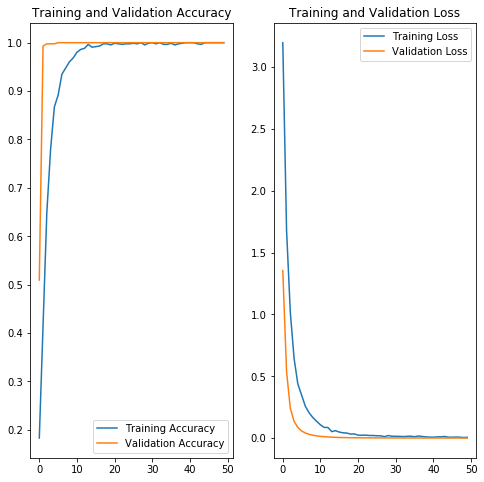

In [4]:
# Fit the model
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
session = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[earlystopper])

acc = session.history['acc']
val_acc = session.history['val_acc']

loss = session.history['loss']
val_loss = session.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see above that the earlystopper did not kick in, the validation loss decreased continously throughout the training session, but we have a validation accuracy of 100%. At first sight, this might seem strange, but remember, we are training on computer genererated numbers, so the numbers are very similar and the model will be used to predict computer generated numbers.

Now we have our final model, ready to be used in the project to predict numbers! 

In [5]:
model.save("../Project" + "\Final model")